In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load preprocessed data
artifacts_dir = '../artifacts'

data = joblib.load(os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
vectorizer = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))

# Extract data components - combine all splits for clustering
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']

# Combine all data for clustering (unsupervised learning)
from scipy.sparse import vstack
X_all = vstack([X_train, X_val, X_test])
y_all = pd.concat([y_train, y_val, y_test], ignore_index=True)

print(f"Combined dataset for clustering: {X_all.shape}")
print(f"Total documents: {len(y_all)}")
print(f"Feature dimensions: {X_all.shape[1]}")
print(f"True labels available for evaluation: {len(class_names)} classes")

Combined dataset for clustering: (2464, 5000)
Total documents: 2464
Feature dimensions: 5000
True labels available for evaluation: 13 classes


In [3]:
# Determine optimal number of clusters using multiple methods
# Test range of cluster numbers
k_range = range(2, 21)  # Test 2 to 20 clusters
inertias = []
silhouette_scores = []

for k in k_range:
    print(f"Testing k={k}...", end=' ')
    
    # Fit k-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_all)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_all, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Silhouette: {silhouette_avg:.3f}")

print("\nCluster analysis completed!")

Testing k=2... Silhouette: 0.022
Testing k=3... Silhouette: 0.024
Testing k=4... Silhouette: 0.027
Testing k=5... Silhouette: 0.028
Testing k=6... Silhouette: 0.031
Testing k=7... Silhouette: 0.034
Testing k=8... Silhouette: 0.027
Testing k=9... Silhouette: 0.033
Testing k=10... Silhouette: 0.036
Testing k=11... Silhouette: 0.034
Testing k=12... Silhouette: 0.033
Testing k=13... Silhouette: 0.039
Testing k=14... Silhouette: 0.039
Testing k=15... Silhouette: 0.040
Testing k=16... Silhouette: 0.041
Testing k=17... Silhouette: 0.043
Testing k=18... Silhouette: 0.043
Testing k=19... Silhouette: 0.045
Testing k=20... Silhouette: 0.047

Cluster analysis completed!


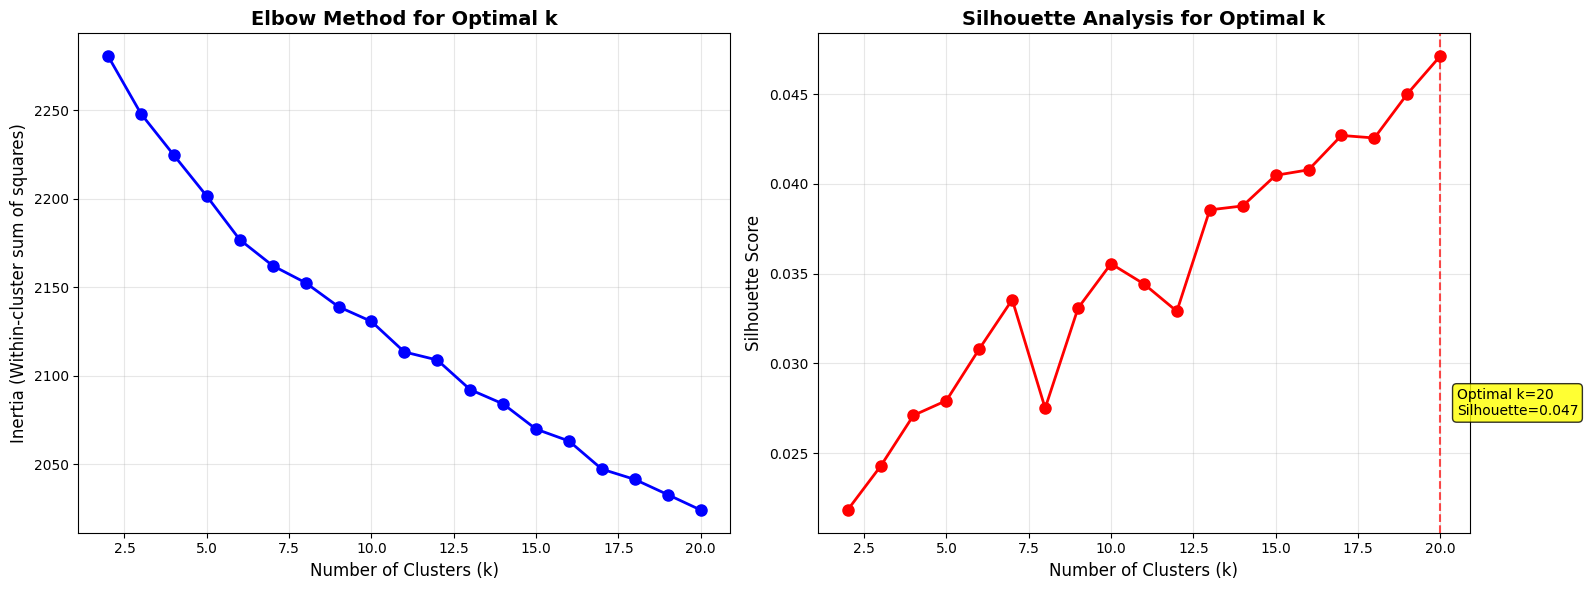

Optimal number of clusters based on Silhouette Score: 20
Maximum Silhouette Score: 0.0471


In [4]:
# Plot elbow curve and silhouette analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Elbow method
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette analysis
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Highlight optimal k based on silhouette score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)
ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7)
ax2.text(optimal_k_silhouette + 0.5, max_silhouette - 0.02, 
         f'Optimal k={optimal_k_silhouette}\nSilhouette={max_silhouette:.3f}', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")
print(f"Maximum Silhouette Score: {max_silhouette:.4f}")

In [5]:
# Compare with the number of true medical specialties
true_k = len(class_names)
print(f"\nComparison with true medical specialties:")
print(f"Number of true medical specialties: {true_k}")
print(f"Optimal k from silhouette analysis: {optimal_k_silhouette}")

# Test both the optimal k and the true number of specialties
k_values_to_test = [optimal_k_silhouette, true_k]
if optimal_k_silhouette == true_k:
    k_values_to_test = [optimal_k_silhouette]

print(f"\nWill analyze clustering results for k = {k_values_to_test}")


Comparison with true medical specialties:
Number of true medical specialties: 13
Optimal k from silhouette analysis: 20

Will analyze clustering results for k = [20, 13]


In [6]:
# Implement k-means with optimal k
final_k = optimal_k_silhouette

# Fit final k-means model
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=20)
cluster_labels = final_kmeans.fit_predict(X_all)

# Calculate final metrics
final_silhouette = silhouette_score(X_all, cluster_labels)
final_inertia = final_kmeans.inertia_

print(f"Clustering completed!")
print(f"Final silhouette score: {final_silhouette:.4f}")
print(f"Final inertia: {final_inertia:.2f}")
print(f"Cluster sizes: {Counter(cluster_labels)}")

Clustering completed!
Final silhouette score: 0.0476
Final inertia: 2021.84
Cluster sizes: Counter({np.int32(4): 335, np.int32(2): 272, np.int32(10): 221, np.int32(1): 170, np.int32(12): 147, np.int32(14): 141, np.int32(3): 137, np.int32(5): 131, np.int32(17): 122, np.int32(13): 114, np.int32(18): 114, np.int32(6): 85, np.int32(16): 84, np.int32(9): 81, np.int32(15): 68, np.int32(19): 63, np.int32(8): 57, np.int32(11): 43, np.int32(7): 40, np.int32(0): 39})


In [7]:
# Analyze cluster composition with respect to true medical specialties
print("CLUSTER COMPOSITION ANALYSIS")
print("=" * 50)

# Create a DataFrame for analysis
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'true_specialty': y_all
})

# Calculate cluster-specialty crosstab
crosstab = pd.crosstab(cluster_df['cluster'], cluster_df['true_specialty'], 
                      margins=True, margins_name='Total')

print("\nCluster vs Medical Specialty Cross-tabulation:")
print(crosstab)

# Calculate purity of each cluster
cluster_purity = {}
for cluster_id in range(final_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_specialties = y_all[cluster_mask]
    most_common_specialty = cluster_specialties.mode()[0]
    purity = (cluster_specialties == most_common_specialty).mean()
    cluster_purity[cluster_id] = {
        'dominant_specialty': most_common_specialty,
        'purity': purity,
        'size': len(cluster_specialties)
    }

print(f"\nCluster Purity Analysis:")
for cluster_id, info in cluster_purity.items():
    print(f"Cluster {cluster_id}: {info['dominant_specialty']} ")
    print(f"  Purity: {info['purity']:.3f} ({info['size']} documents)")

CLUSTER COMPOSITION ANALYSIS

Cluster vs Medical Specialty Cross-tabulation:
true_specialty  Cardiovascular / Pulmonary  ENT - Otolaryngology  \
cluster                                                            
0                                        0                     0   
1                                        4                     1   
2                                      114                    35   
3                                      128                     0   
4                                      124                     1   
5                                        2                     0   
6                                        0                     1   
7                                       38                     0   
8                                        0                     0   
9                                        0                     0   
10                                      68                    18   
11                                     

In [8]:
# Dimensionality reduction for visualization
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all.toarray())

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# t-SNE for better cluster separation (on a sample for computational efficiency)
sample_size = min(1000, X_all.shape[0])  # Use up to 1000 samples for t-SNE
sample_indices = np.random.choice(X_all.shape[0], sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_all[sample_indices].toarray())
cluster_labels_sample = cluster_labels[sample_indices]
y_all_sample = y_all.iloc[sample_indices]

PCA explained variance ratio: [0.02789178 0.01819349]
Total variance explained: 0.046


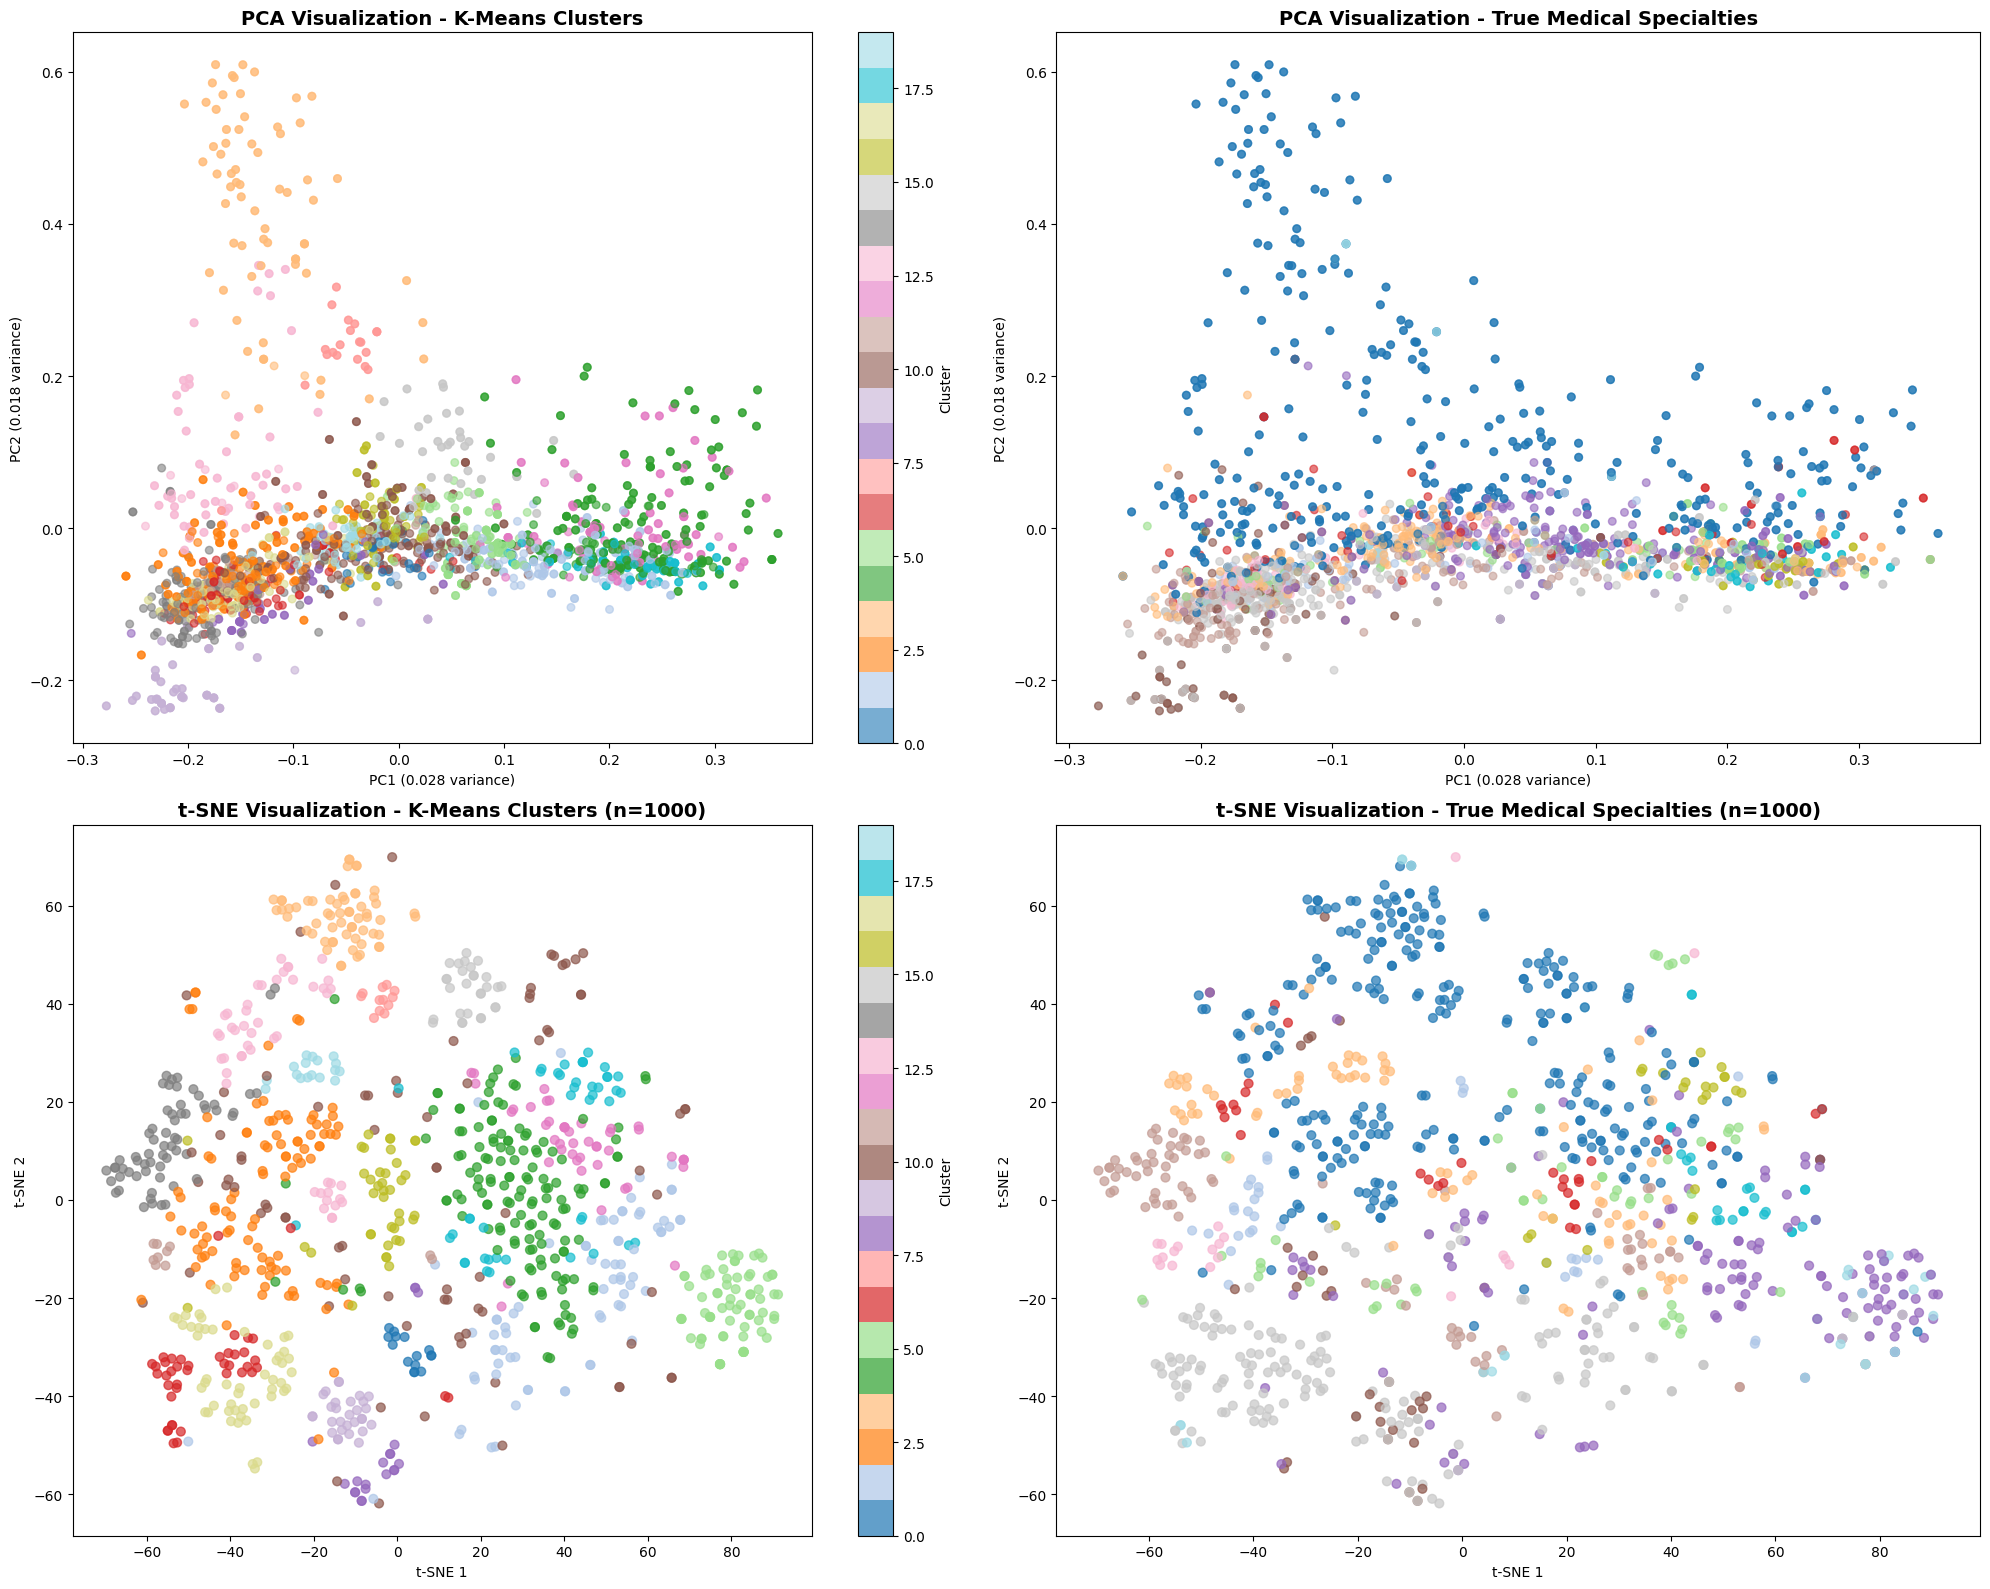

In [9]:
# Plot cluster visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# PCA with clusters
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                             cmap='tab20', alpha=0.6, s=30)
axes[0, 0].set_title('PCA Visualization - K-Means Clusters', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# PCA with true specialties
specialty_colors = {specialty: i for i, specialty in enumerate(class_names)}
true_colors = [specialty_colors[specialty] for specialty in y_all]
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=true_colors, 
                             cmap='tab20', alpha=0.6, s=30)
axes[0, 1].set_title('PCA Visualization - True Medical Specialties', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')

# t-SNE with clusters
scatter3 = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels_sample, 
                             cmap='tab20', alpha=0.7, s=40)
axes[1, 0].set_title(f't-SNE Visualization - K-Means Clusters (n={sample_size})', 
                    fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# t-SNE with true specialties
true_colors_sample = [specialty_colors[specialty] for specialty in y_all_sample]
scatter4 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_colors_sample, 
                             cmap='tab20', alpha=0.7, s=40)
axes[1, 1].set_title(f't-SNE Visualization - True Medical Specialties (n={sample_size})', 
                    fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [10]:
# Analyze cluster centroids to understand cluster characteristics
print("CLUSTER CHARACTERIZATION ANALYSIS")
print("=" * 50)

# Get cluster centroids
centroids = final_kmeans.cluster_centers_

# Function to get top words for a centroid
def get_top_words(centroid, feature_names, n_words=10):
    top_indices = centroid.argsort()[-n_words:][::-1]
    top_words = [(feature_names[i], centroid[i]) for i in top_indices]
    return top_words

# Analyze each cluster
cluster_characteristics = {}

for cluster_id in range(final_k):
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*60}")
    
    # Get cluster info
    cluster_info = cluster_purity[cluster_id]
    centroid = centroids[cluster_id]
    
    print(f"Size: {cluster_info['size']} documents")
    print(f"Dominant Medical Specialty: {cluster_info['dominant_specialty']}")
    print(f"Purity: {cluster_info['purity']:.3f}")
    
    # Get top defining words
    top_words = get_top_words(centroid, feature_names, 15)
    
    print(f"\nTop Defining Terms:")
    for i, (word, score) in enumerate(top_words, 1):
        print(f"  {i:2d}. {word:<20} (score: {score:.4f})")
    
    # Analyze specialty distribution within cluster
    cluster_mask = cluster_labels == cluster_id
    cluster_specialties = y_all[cluster_mask].value_counts()
    
    print(f"\nSpecialty Distribution:")
    for specialty, count in cluster_specialties.items():
        percentage = (count / cluster_info['size']) * 100
        print(f"  {specialty:<25} {count:3d} documents ({percentage:5.1f}%)")
    
    # Store characteristics for later analysis
    cluster_characteristics[cluster_id] = {
        'size': cluster_info['size'],
        'dominant_specialty': cluster_info['dominant_specialty'],
        'purity': cluster_info['purity'],
        'top_words': [word for word, score in top_words[:10]],
        'specialty_distribution': cluster_specialties.to_dict()
    }

CLUSTER CHARACTERIZATION ANALYSIS

CLUSTER 0
Size: 39 documents
Dominant Medical Specialty: Obstetrics / Gynecology
Purity: 0.795

Top Defining Terms:
   1. fetal                (score: 0.2983)
   2. weeks days           (score: 0.1473)
   3. placenta             (score: 0.1453)
   4. delivery             (score: 0.1122)
   5. weeks                (score: 0.1101)
   6. gestation            (score: 0.1085)
   7. consistent           (score: 0.0899)
   8. days                 (score: 0.0826)
   9. baby                 (score: 0.0813)
  10. amniotic fluid       (score: 0.0727)
  11. amniotic             (score: 0.0722)
  12. fl                   (score: 0.0693)
  13. 33                   (score: 0.0686)
  14. normal               (score: 0.0667)
  15. hc                   (score: 0.0660)

Specialty Distribution:
  Obstetrics / Gynecology    31 documents ( 79.5%)
  Radiology                   8 documents ( 20.5%)

CLUSTER 1
Size: 170 documents
Dominant Medical Specialty: Neurology
Purity: 

In [11]:
# Business insights analysis
print("BUSINESS INSIGHTS FOR MEDARCHIVE SOLUTIONS")
print("=" * 60)

# 1. Identify potential sub-specialties
print("\n1. POTENTIAL SUB-SPECIALTIES IDENTIFIED:")

sub_specialties = []
for cluster_id, info in cluster_characteristics.items():
    if info['purity'] > 0.7:  # High purity clusters indicate clear sub-specialties
        # Look for specific procedure or condition keywords
        top_words = info['top_words']
        medical_terms = [word for word in top_words if len(word) > 3 and 
                        any(medical_keyword in word.lower() for medical_keyword in 
                            ['surgery', 'procedure', 'treatment', 'therapy', 'diagnosis', 
                             'examination', 'consultation', 'patient', 'clinical'])]
        
        if medical_terms:
            sub_specialty_name = f"{info['dominant_specialty']} - {', '.join(medical_terms[:3])}"
            sub_specialties.append({
                'cluster_id': cluster_id,
                'name': sub_specialty_name,
                'parent_specialty': info['dominant_specialty'],
                'size': info['size'],
                'purity': info['purity'],
                'key_terms': medical_terms[:5]
            })

if sub_specialties:
    for sub in sub_specialties:
        print(f"   • {sub['name']}")
        print(f"     Parent: {sub['parent_specialty']}")
        print(f"     Size: {sub['size']} documents, Purity: {sub['purity']:.3f}")
        print(f"     Key terms: {', '.join(sub['key_terms'])}")
        print()
else:
    print("   No clear sub-specialties identified with current clustering")

# 2. Cross-specialty patterns
print("\n2. CROSS-SPECIALTY PATTERNS:")

mixed_clusters = []
for cluster_id, info in cluster_characteristics.items():
    if info['purity'] < 0.6:  # Mixed clusters indicate cross-specialty patterns
        mixed_clusters.append({
            'cluster_id': cluster_id,
            'size': info['size'],
            'purity': info['purity'],
            'specialties': info['specialty_distribution'],
            'top_words': info['top_words'][:5]
        })

if mixed_clusters:
    for cluster in mixed_clusters:
        print(f"   Cluster {cluster['cluster_id']} ({cluster['size']} docs, purity: {cluster['purity']:.3f}):")
        print(f"     Mixed specialties: {list(cluster['specialties'].keys())[:3]}")
        print(f"     Common themes: {', '.join(cluster['top_words'])}")
        print()
else:
    print("   All clusters show clear specialty separation")

# 3. Operational recommendations
print("\n3. OPERATIONAL RECOMMENDATIONS:")

total_clusters = len(cluster_characteristics)
avg_purity = np.mean([info['purity'] for info in cluster_characteristics.values()])
largest_cluster = max(cluster_characteristics.values(), key=lambda x: x['size'])
smallest_cluster = min(cluster_characteristics.values(), key=lambda x: x['size'])

print(f"   • Total natural groupings discovered: {total_clusters}")
print(f"   • Average cluster purity: {avg_purity:.3f}")
print(f"   • Largest cluster: {largest_cluster['size']} documents ({largest_cluster['dominant_specialty']})")
print(f"   • Smallest cluster: {smallest_cluster['size']} documents ({smallest_cluster['dominant_specialty']})")

if avg_purity > 0.7:
    print(f"   ✅ High cluster quality suggests clear document groupings")
    print(f"   📊 Recommend implementing sub-specialty routing based on clusters")
else:
    print(f"   ⚠️  Mixed cluster quality suggests overlapping specialties")
    print(f"   🔍 Recommend human review for ambiguous cases")

BUSINESS INSIGHTS FOR MEDARCHIVE SOLUTIONS

1. POTENTIAL SUB-SPECIALTIES IDENTIFIED:
   • Orthopedic - patient
     Parent: Orthopedic
     Size: 85 documents, Purity: 0.929
     Key terms: patient

   • Cardiovascular / Pulmonary - procedure, patient
     Parent: Cardiovascular / Pulmonary
     Size: 114 documents, Purity: 0.895
     Key terms: procedure, patient

   • Orthopedic - patient
     Parent: Orthopedic
     Size: 122 documents, Purity: 0.926
     Key terms: patient

   • Gastroenterology - procedure
     Parent: Gastroenterology
     Size: 63 documents, Purity: 1.000
     Key terms: procedure


2. CROSS-SPECIALTY PATTERNS:
   Cluster 1 (170 docs, purity: 0.394):
     Mixed specialties: ['Neurology', 'Orthopedic', 'Psychiatry / Psychology']
     Common themes: pain, patient, history, right, states

   Cluster 2 (272 docs, purity: 0.419):
     Mixed specialties: ['Cardiovascular / Pulmonary', 'Neurosurgery', 'ENT - Otolaryngology']
     Common themes: procedure, patient, lobe

In [12]:
# Cluster evaluation metrics
print("\n4. CLUSTERING QUALITY METRICS:")

# Calculate various clustering metrics
# Convert true labels to numeric for metric calculation
label_to_num = {label: i for i, label in enumerate(class_names)}
y_all_numeric = [label_to_num[label] for label in y_all]

# Compute Silhouette Score
final_silhouette = silhouette_score(X_all, cluster_labels)

ari = adjusted_rand_score(y_all_numeric, cluster_labels)
nmi = normalized_mutual_info_score(y_all_numeric, cluster_labels)

print(f"   • Silhouette Score: {final_silhouette:.4f} (higher is better, range: -1 to 1)")
print(f"   • Adjusted Rand Index: {ari:.4f} (higher is better, range: -1 to 1)")
print(f"   • Normalized Mutual Information: {nmi:.4f} (higher is better, range: 0 to 1)")
print(f"   • Average Cluster Purity: {avg_purity:.4f} (higher is better, range: 0 to 1)")

# Interpretation
print(f"\n   INTERPRETATION:")
if final_silhouette > 0.3:
    print(f"   ✅ Good cluster separation (Silhouette > 0.3)")
elif final_silhouette > 0.1:
    print(f"   ⚠️  Moderate cluster separation (Silhouette 0.1-0.3)")
else:
    print(f"   ❌ Poor cluster separation (Silhouette < 0.1)")

if ari > 0.3:
    print(f"   ✅ Good agreement with true specialties (ARI > 0.3)")
elif ari > 0.1:
    print(f"   ⚠️  Moderate agreement with true specialties (ARI 0.1-0.3)")
else:
    print(f"   ❌ Poor agreement with true specialties (ARI < 0.1)")


4. CLUSTERING QUALITY METRICS:
   • Silhouette Score: 0.0476 (higher is better, range: -1 to 1)
   • Adjusted Rand Index: 0.1364 (higher is better, range: -1 to 1)
   • Normalized Mutual Information: 0.3990 (higher is better, range: 0 to 1)
   • Average Cluster Purity: 0.6641 (higher is better, range: 0 to 1)

   INTERPRETATION:
   ❌ Poor cluster separation (Silhouette < 0.1)
   ⚠️  Moderate agreement with true specialties (ARI 0.1-0.3)


In [13]:
# Detailed analysis of most interesting clusters
print("DETAILED CLUSTER ANALYSIS")
print("=" * 50)

# Sort clusters by interesting metrics
clusters_by_purity = sorted(cluster_characteristics.items(), 
                           key=lambda x: x[1]['purity'], reverse=True)
clusters_by_size = sorted(cluster_characteristics.items(), 
                         key=lambda x: x[1]['size'], reverse=True)

print("\nHIGHEST PURITY CLUSTERS (Most Specialized):")
for i, (cluster_id, info) in enumerate(clusters_by_purity[:3]):
    print(f"\n{i+1}. Cluster {cluster_id} - {info['dominant_specialty']}")
    print(f"   Purity: {info['purity']:.3f} | Size: {info['size']} documents")
    print(f"   Specialized for: {', '.join(info['top_words'][:5])}")
    
    # Business value
    if info['purity'] > 0.8:
        print(f"   💡 HIGH VALUE: Perfect for automated routing to {info['dominant_specialty']}")
    elif info['purity'] > 0.6:
        print(f"   💡 GOOD VALUE: Reliable routing with minimal human review")

print("\n\nLARGEST CLUSTERS (High Volume):")
for i, (cluster_id, info) in enumerate(clusters_by_size[:3]):
    print(f"\n{i+1}. Cluster {cluster_id} - {info['dominant_specialty']}")
    print(f"   Size: {info['size']} documents | Purity: {info['purity']:.3f}")
    print(f"   Key themes: {', '.join(info['top_words'][:5])}")
    
    # Calculate potential time savings
    manual_time_per_doc = 2  # minutes
    automated_time_per_doc = 0.1  # minutes
    time_saved_per_doc = manual_time_per_doc - automated_time_per_doc
    daily_docs = info['size'] * (1000 / len(y_all))  # Scale to daily volume
    daily_time_saved = daily_docs * time_saved_per_doc
    
    print(f"   💰 IMPACT: ~{daily_time_saved:.0f} minutes saved daily if automated")

DETAILED CLUSTER ANALYSIS

HIGHEST PURITY CLUSTERS (Most Specialized):

1. Cluster 11 - Ophthalmology
   Purity: 1.000 | Size: 43 documents
   Specialized for: eye, chamber, right eye, lens, anterior chamber
   💡 HIGH VALUE: Perfect for automated routing to Ophthalmology

2. Cluster 19 - Gastroenterology
   Purity: 1.000 | Size: 63 documents
   Specialized for: colon, scope, esophagus, procedure, stomach
   💡 HIGH VALUE: Perfect for automated routing to Gastroenterology

3. Cluster 15 - Cardiovascular / Pulmonary
   Purity: 0.971 | Size: 68 documents
   Specialized for: stress, heart rate, rate, heart, perfusion
   💡 HIGH VALUE: Perfect for automated routing to Cardiovascular / Pulmonary


LARGEST CLUSTERS (High Volume):

1. Cluster 4 - Cardiovascular / Pulmonary
   Size: 335 documents | Purity: 0.370
   Key themes: history, patient, pain, denies, past
   💰 IMPACT: ~258 minutes saved daily if automated

2. Cluster 2 - Cardiovascular / Pulmonary
   Size: 272 documents | Purity: 0.419
  

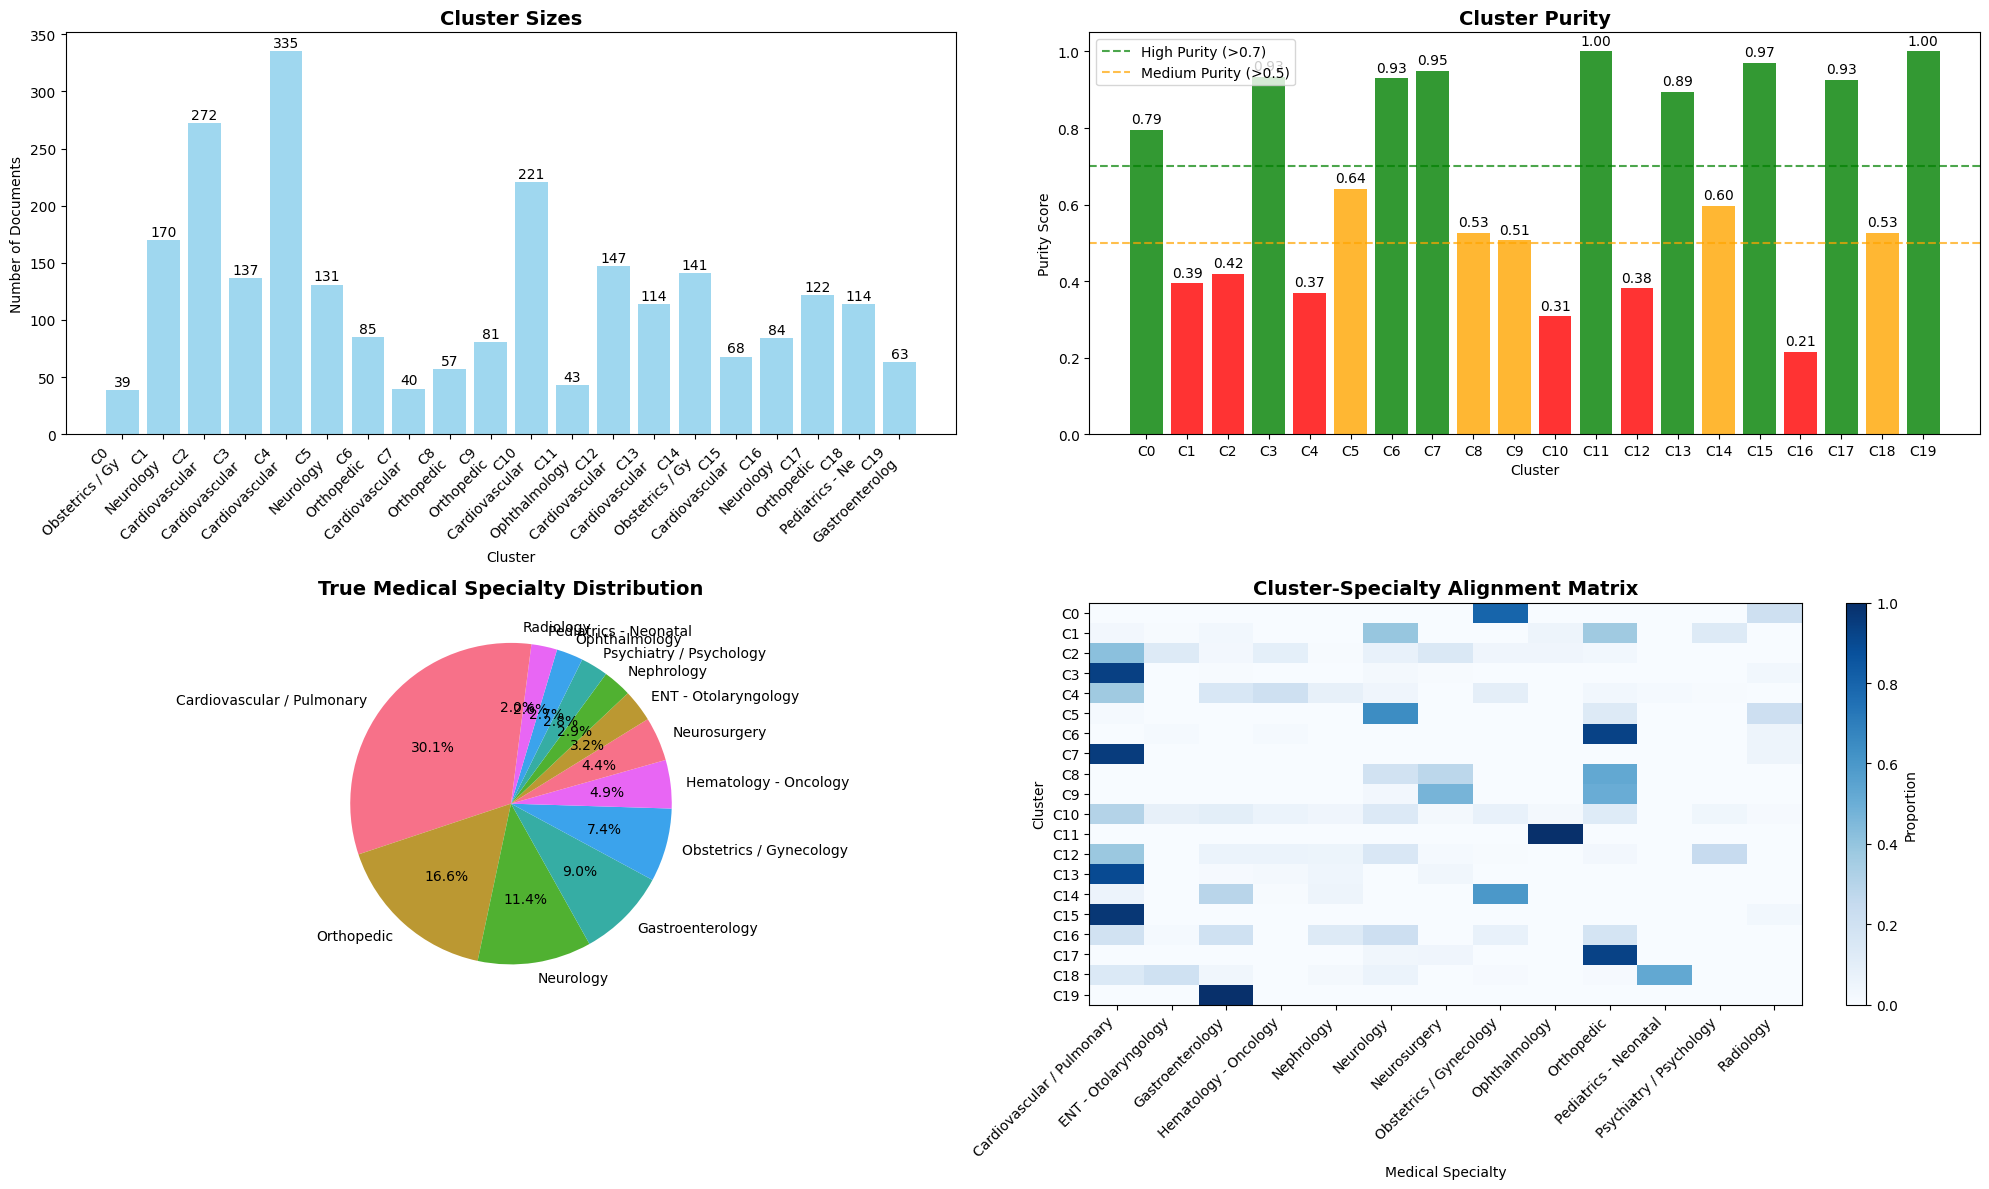

In [14]:
# Create a comprehensive cluster summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1. Cluster sizes
cluster_ids = list(cluster_characteristics.keys())
cluster_sizes = [cluster_characteristics[i]['size'] for i in cluster_ids]
cluster_labels_plot = [f"C{i}\n{cluster_characteristics[i]['dominant_specialty'][:15]}" for i in cluster_ids]

bars1 = ax1.bar(range(len(cluster_ids)), cluster_sizes, color='skyblue', alpha=0.8)
ax1.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Documents')
ax1.set_xticks(range(len(cluster_ids)))
ax1.set_xticklabels(cluster_labels_plot, rotation=45, ha='right')

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom')

# 2. Cluster purity
cluster_purities = [cluster_characteristics[i]['purity'] for i in cluster_ids]
colors = ['green' if p > 0.7 else 'orange' if p > 0.5 else 'red' for p in cluster_purities]

bars2 = ax2.bar(range(len(cluster_ids)), cluster_purities, color=colors, alpha=0.8)
ax2.set_title('Cluster Purity', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Purity Score')
ax2.set_xticks(range(len(cluster_ids)))
ax2.set_xticklabels([f'C{i}' for i in cluster_ids])
ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.7, label='High Purity (>0.7)')
ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium Purity (>0.5)')
ax2.legend()

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom')

# 3. Specialty distribution pie chart
specialty_counts = y_all.value_counts()
ax3.pie(specialty_counts.values, labels=specialty_counts.index, autopct='%1.1f%%',
        startangle=90)
ax3.set_title('True Medical Specialty Distribution', fontsize=14, fontweight='bold')

# 4. Cluster vs Specialty alignment
cluster_specialty_matrix = np.zeros((final_k, len(class_names)))
for cluster_id in range(final_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_specialties = y_all[cluster_mask]
    for j, specialty in enumerate(class_names):
        cluster_specialty_matrix[cluster_id, j] = (cluster_specialties == specialty).sum()

# Normalize by cluster size
cluster_specialty_matrix = cluster_specialty_matrix / cluster_specialty_matrix.sum(axis=1, keepdims=True)

im = ax4.imshow(cluster_specialty_matrix, cmap='Blues', aspect='auto')
ax4.set_title('Cluster-Specialty Alignment Matrix', fontsize=14, fontweight='bold')
ax4.set_xlabel('Medical Specialty')
ax4.set_ylabel('Cluster')
ax4.set_xticks(range(len(class_names)))
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.set_yticks(range(final_k))
ax4.set_yticklabels([f'C{i}' for i in range(final_k)])
plt.colorbar(im, ax=ax4, label='Proportion')

plt.tight_layout()
plt.show()

In [15]:
# Save clustering results
clustering_results = {
    'model': final_kmeans,
    'optimal_k': final_k,
    'cluster_labels': cluster_labels,
    'cluster_characteristics': cluster_characteristics,
    'metrics': {
        'silhouette_score': final_silhouette,
        'inertia': final_inertia,
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'average_purity': avg_purity
    },
    'business_insights': {
        'sub_specialties': sub_specialties,
        'mixed_clusters': mixed_clusters,
        'high_purity_clusters': [id for id, info in clusters_by_purity[:3]],
        'largest_clusters': [id for id, info in clusters_by_size[:3]]
    },
    'cluster_centroids': centroids,
    'pca_transform': pca,
    'X_pca': X_pca
}

joblib.dump(clustering_results, os.path.join(artifacts_dir, 'clustering_results.joblib'))

print("Clustering results saved successfully!")
print(f"File saved: {artifacts_dir}/clustering_results.joblib")


Clustering results saved successfully!
File saved: ../artifacts/clustering_results.joblib


In [16]:
print("=" * 80)
print("CLUSTERING ANALYSIS SUMMARY FOR MEDARCHIVE SOLUTIONS")
print("=" * 80)

print(f"\n🔍 CLUSTERING OVERVIEW:")
print(f"   • Optimal clusters discovered: {final_k}")
print(f"   • Total documents analyzed: {len(y_all)}")
print(f"   • Clustering quality (Silhouette): {final_silhouette:.3f}")
print(f"   • Average cluster purity: {avg_purity:.3f}")

print(f"\n💡 KEY DISCOVERIES:")
print(f"   • {len([info for info in cluster_characteristics.values() if info['purity'] > 0.7])} high-purity clusters suitable for automated routing")
print(f"   • {len(sub_specialties)} potential sub-specialties identified")
print(f"   • {len(mixed_clusters)} cross-specialty patterns found")

high_value_clusters = [info for info in cluster_characteristics.values() if info['purity'] > 0.7 and info['size'] > 50]
if high_value_clusters:
    total_high_value_docs = sum([info['size'] for info in high_value_clusters])
    automation_rate = total_high_value_docs / len(y_all)
    print(f"   • {automation_rate:.1%} of documents can be automatically routed with high confidence")

print(f"\n🏥 BUSINESS APPLICATIONS:")
print(f"   1. SUB-SPECIALTY ROUTING:")
if sub_specialties:
    for sub in sub_specialties[:3]:  # Show top 3
        print(f"      • {sub['parent_specialty']} → {', '.join(sub['key_terms'][:2])}")
else:
    print(f"      • Current clustering aligns well with existing specialty categories")

print(f"\n   2. DOCUMENT TRIAGE OPTIMIZATION:")
print(f"      • High-confidence routing: {len([info for info in cluster_characteristics.values() if info['purity'] > 0.8])} clusters")
print(f"      • Requires human review: {len([info for info in cluster_characteristics.values() if info['purity'] < 0.6])} clusters")

print(f"\n   3. OPERATIONAL EFFICIENCY:")
# Calculate potential time savings
automated_docs = sum([info['size'] for info in cluster_characteristics.values() if info['purity'] > 0.7])
automation_percentage = (automated_docs / len(y_all)) * 100
daily_savings_minutes = (automated_docs / len(y_all)) * 1000 * 1.9  # 1.9 minutes saved per doc
monthly_savings_hours = daily_savings_minutes * 22 / 60  # 22 working days

print(f"      • Documents suitable for automation: {automation_percentage:.1f}%")
print(f"      • Estimated daily time savings: {daily_savings_minutes:.0f} minutes")
print(f"      • Estimated monthly savings: {monthly_savings_hours:.0f} hours")

print(f"\n📊 QUALITY METRICS:")
print(f"   • Silhouette Score: {final_silhouette:.3f} (cluster separation)")
print(f"   • Adjusted Rand Index: {ari:.3f} (alignment with true specialties)")
print(f"   • Cluster Purity Range: {min([info['purity'] for info in cluster_characteristics.values()]):.3f} - {max([info['purity'] for info in cluster_characteristics.values()]):.3f}")

print(f"\n🚀 RECOMMENDATIONS:")
print(f"   1. Implement cluster-based routing for high-purity clusters")
print(f"   2. Use clustering insights to enhance classification model")
print(f"   3. Monitor cluster stability over time with new data")
print(f"   4. Consider ensemble approach combining classification + clustering")

if final_silhouette > 0.3 and avg_purity > 0.6:
    print(f"\n✅ CLUSTERING ANALYSIS: HIGH VALUE FOR PRODUCTION DEPLOYMENT")
elif final_silhouette > 0.1 and avg_purity > 0.4:
    print(f"\n⚠️  CLUSTERING ANALYSIS: MODERATE VALUE, CONSIDER REFINEMENTS")
else:
    print(f"\n❌ CLUSTERING ANALYSIS: LIMITED VALUE, FOCUS ON CLASSIFICATION")

print("\n" + "=" * 80)

CLUSTERING ANALYSIS SUMMARY FOR MEDARCHIVE SOLUTIONS

🔍 CLUSTERING OVERVIEW:
   • Optimal clusters discovered: 20
   • Total documents analyzed: 2464
   • Clustering quality (Silhouette): 0.048
   • Average cluster purity: 0.664

💡 KEY DISCOVERIES:
   • 9 high-purity clusters suitable for automated routing
   • 4 potential sub-specialties identified
   • 10 cross-specialty patterns found
   • 23.9% of documents can be automatically routed with high confidence

🏥 BUSINESS APPLICATIONS:
   1. SUB-SPECIALTY ROUTING:
      • Orthopedic → patient
      • Cardiovascular / Pulmonary → procedure, patient
      • Orthopedic → patient

   2. DOCUMENT TRIAGE OPTIMIZATION:
      • High-confidence routing: 8 clusters
      • Requires human review: 10 clusters

   3. OPERATIONAL EFFICIENCY:
      • Documents suitable for automation: 28.9%
      • Estimated daily time savings: 548 minutes
      • Estimated monthly savings: 201 hours

📊 QUALITY METRICS:
   • Silhouette Score: 0.048 (cluster separation